In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
from models import create_model 
import pandas as pd

import yaml
import torch
from pipeline.walkforward import WFCVGenerator
from utils.paths import CONFIG_DIR, VOL_EXPERIMENTS_DIR, DATA_DIR, PRICE_EXPERIMENTS_DIR

from config.config_types import AppConfig


import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import json


In [3]:

fold_num = 0
name  = "exp_024_lstm_40_search"
trial = "trial_search_best" 

# -------- load config --------
base = f"{VOL_EXPERIMENTS_DIR}/{name}/{trial}/"
conifg_path = f"{base}config_snapshot.json"

with open(conifg_path, 'r') as f:
    cfg = json.load(f)

cfg = cfg["cfg"]

cfg = AppConfig.from_dict(cfg)

if cfg.data["df_master"] is not None:
    df_master_path =  cfg.data["df_master"]
    df_master = pd.read_parquet(f"{DATA_DIR}/{df_master_path}")
    #print(f"provided df master: {df_master_path}\n{df_master.head()}")
else:
    df_master = None

wf = WFCVGenerator(config=cfg.walkforward)


In [4]:
results = pd.read_csv(f"{base}/results.csv")
results


,trial,fold,tr_loss,val_loss,test_loss,tr_mae,val_mae,test_mae,tr_directional_accuracy_pct,val_directional_accuracy_pct,test_directional_accuracy_pct,tr_undershooting_pct,val_undershooting_pct,test_undershooting_pct,seconds,model_path
0,-1,0,0.493252,NaN,0.455230,0.549656,NaN,0.527040,77.035676,NaN,88.213933,-0.000250,NaN,-0.000657,919.869534,/orcd/home/002/corte911/code/finNN_code/src/vo...
1,-1,1,0.464873,NaN,0.449236,0.533163,NaN,0.522774,78.158262,NaN,83.756438,0.001220,NaN,0.000595,925.861370,/orcd/home/002/corte911/code/finNN_code/src/vo...
2,-1,2,0.453568,NaN,0.421949,0.525908,NaN,0.504499,77.561003,NaN,79.745681,0.000438,NaN,0.000054,926.222109,/orcd/home/002/corte911/code/finNN_code/src/vo...
3,-1,3,0.571944,NaN,0.627617,0.590393,NaN,0.618808,74.041295,NaN,73.682121,-0.000264,NaN,0.000452,922.559687,/orcd/home/002/corte911/code/finNN_code/src/vo...
4,-1,4,0.602756,NaN,0.552311,0.607431,NaN,0.583213,73.322297,NaN,86.129078,-0.000448,NaN,0.000995,914.440634,/orcd/home/002/corte911/code/finNN_code/src/vo...
5,-1,5,0.556314,NaN,0.451788,0.581891,NaN,0.530088,76.087976,NaN,84.307553,-0.000158,NaN,-0.001261,863.868464,/orcd/home/002/corte911/code/finNN_code/src/vo...
6,-1,6,0.343866,NaN,0.331759,0.457536,NaN,0.443680,79.855991,NaN,76.438056,-0.001253,NaN,-0.001647,930.357565,/orcd/home/002/corte911/code/finNN_code/src/vo...
7,-1,7,0.350928,NaN,0.325054,0.460963,NaN,0.446605,80.985133,NaN,80.729231,-0.000562,NaN,-0.000581,931.540669,/orcd/home/002/corte911/code/finNN_code/src/vo...
8,-1,8,0.336063,NaN,0.328134,0.450942,NaN,0.445707,80.932186,NaN,87.535570,-0.000108,NaN,-0.000984,934.619508,/orcd/home/002/corte911/code/finNN_code/src/vo...
9,-1,9,0.429968,NaN,0.451121,0.510209,NaN,0.522689,78.803271,NaN,83.603464,-0.000134,NaN,-0.000620,939.126450,/orcd/home/002/corte911/code/finNN_code/src/vo...


In [5]:
results.drop(columns="model_path").mean().apply(lambda x: round(x, 5))

trial                             -1.00000
fold                              10.00000
tr_loss                            0.50218
val_loss                               NaN
test_loss                          0.49354
tr_mae                             0.55153
val_mae                                NaN
test_mae                           0.54604
tr_directional_accuracy_pct       75.79463
val_directional_accuracy_pct           NaN
test_directional_accuracy_pct     78.45035
tr_undershooting_pct              -0.00034
val_undershooting_pct                  NaN
test_undershooting_pct            -0.00040
seconds                          921.17362
dtype: float64

In [6]:

test_data = {}
data = {}
for i, fold_data in enumerate(wf.folds()):
    X_test = fold_data[4]
    y_test = fold_data[5]

    test_data[i] = [X_test, y_test]
    data[i] = fold_data
    print(i)
    #if i == fold_num:
    #    break


0
1
1
2
2
3
3
4
4
5
5
6
6
7
7
8
8
9
9
10
10
11
11
12
12
13
13
14
14
15
15
16
16
17
17
18
18
19
19
20
20


In [7]:
pd.DataFrame(X_test).describe()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
count,104880.000000,104880.000000,104880.000000,104880.000000,104880.000000,104880.000000,104880.000000,104880.000000,104880.000000,104880.000000,...,104880.000000,104880.000000,104880.000000,104880.000000,104880.000000,104880.000000,104880.000000,104880.000000,104880.000000,104880.000000
mean,-0.511693,-0.510793,-0.515907,-0.521924,-0.526357,-0.527634,-0.528844,-0.533457,-0.535604,-0.537105,...,-0.527194,-0.525617,-0.524447,-0.527853,-0.530425,-0.534429,-0.537472,-0.539106,-0.540849,-0.539954
std,0.869055,0.870827,0.871815,0.872956,0.875238,0.876861,0.878520,0.882150,0.885346,0.887703,...,0.902884,0.902151,0.901723,0.902083,0.901240,0.899626,0.899180,0.898931,0.897987,0.896959
min,-3.410229,-3.419357,-3.427244,-3.435667,-3.445014,-3.451999,-3.460789,-3.474729,-3.486534,-3.498538,...,-3.561259,-3.561498,-3.560243,-3.561772,-3.561834,-3.561507,-3.561191,-3.560189,-3.560167,-3.557382
25%,-1.107883,-1.108435,-1.113616,-1.120514,-1.126643,-1.129412,-1.131662,-1.138915,-1.143507,-1.146587,...,-1.148515,-1.147052,-1.145939,-1.149138,-1.151257,-1.153554,-1.156493,-1.158593,-1.159308,-1.157456
50%,-0.566211,-0.565285,-0.570088,-0.576914,-0.582575,-0.584220,-0.585835,-0.591448,-0.593612,-0.594814,...,-0.591182,-0.589974,-0.588614,-0.591951,-0.594652,-0.598558,-0.601998,-0.603530,-0.605048,-0.603737
75%,0.022789,0.025305,0.019012,0.013915,0.011482,0.011306,0.010583,0.008444,0.008013,0.007382,...,0.022203,0.023064,0.024021,0.021446,0.018349,0.013561,0.010926,0.009539,0.007119,0.007139
max,3.923593,3.893588,3.903562,3.912472,3.922041,3.929224,3.936561,3.948975,3.959354,3.968806,...,4.032634,4.032776,4.083794,4.081960,4.079870,4.078501,4.075641,4.018944,4.015236,4.009262


In [8]:


hparams = cfg.model.hparams
input_shape = (cfg.walkforward.lags,)
output_shape = cfg.walkforward.lookback+1

ckpt_path = f"{base}fold_{fold_num:03d}/model_best.pt"
checkpoint = torch.load(ckpt_path, map_location="cuda")




In [9]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

sns.set_theme(style="darkgrid", context="talk")

def maybe_inverse(y, scaler):
    return y if scaler is None else scaler.inverse_transform(y.reshape(-1,1)).ravel()


def _prepare_X_for_ols(X: np.ndarray) -> np.ndarray:
    """Flatten to (N, F) for LinearRegression. Handles (N,), (N,T), (N,T,D)."""
    X = np.asarray(X)
    if X.ndim == 1:
        return X.reshape(-1, 1)
    if X.ndim == 2:
        return X
    if X.ndim == 3:
        N, T, D = X.shape
        return X.reshape(N, T*D)
    raise ValueError(f"Unexpected X shape for OLS: {X.shape}")



def plot_split_dims_dual(title, y_true, y_pred_nn, y_pred_ols):
    """
    Side-by-side comparison of NN vs OLS:
    - Figure 1: Scatter + 45° + per-panel linear fit (red) for each model
    - Figure 2: KDE of true vs predicted for each model
    Works for 1-D or multi-D targets.
    """
    y_true     = np.asarray(y_true)
    y_pred_nn  = np.asarray(y_pred_nn)
    y_pred_ols = np.asarray(y_pred_ols)

    # Ensure 2D: (N,) -> (N,1)
    if y_true.ndim == 1:      y_true = y_true.reshape(-1, 1)
    if y_pred_nn.ndim == 1:   y_pred_nn = y_pred_nn.reshape(-1, 1)
    if y_pred_ols.ndim == 1:  y_pred_ols = y_pred_ols.reshape(-1, 1)

    assert y_true.shape == y_pred_nn.shape == y_pred_ols.shape, \
        "y_true, y_pred_nn, y_pred_ols must have the same shape"
    _, K = y_true.shape

    def _fit_stats(yt, yp):
        # Fit regression: y_true ~ y_predicted (consistent with scatter plot axes)
        reg = LinearRegression().fit(yp.reshape(-1,1), yt)
        slope, intercept = reg.coef_[0], reg.intercept_
        r2   = r2_score(yt, yp)
        rmse = np.sqrt(mean_squared_error(yt, yp))
        return reg, slope, intercept, r2, rmse

    # ---------- SINGLE-OUTPUT ----------
    if K == 1:
        yt = y_true[:, 0]
        yp_nn  = y_pred_nn[:, 0]
        yp_ols = y_pred_ols[:, 0]

        lo = min(yt.min(), yp_nn.min(), yp_ols.min())
        hi = max(yt.max(), yp_nn.max(), yp_ols.max())
        pad = 0.02 * (hi - lo); lo -= pad; hi += pad
        x_line = np.linspace(lo, hi, 200)

        reg_nn, slope_nn, int_nn, r2_nn, rmse_nn = _fit_stats(yt, yp_nn)
        y_line_nn  = reg_nn.predict(x_line.reshape(-1,1))

        reg_ols, slope_ols, int_ols, r2_ols, rmse_ols = _fit_stats(yt, yp_ols)
        y_line_ols = reg_ols.predict(x_line.reshape(-1,1))

        # Scatter panels (NN | OLS) - True on Y, Predicted on X
        fig, axes = plt.subplots(1, 2, figsize=(14, 6), squeeze=False)
        axL, axR = axes[0]

        axL.scatter(yp_nn, yt, s=8, alpha=0.5, edgecolors="none")
        axL.plot([lo, hi], [lo, hi], 'k--', lw=1, label="45° line")
        axL.plot(x_line, y_line_nn, 'r-', lw=2, label=f'Fit: y={slope_nn:.3f}x+{int_nn:.3f}')
        axL.set_title(f"NN — R²={r2_nn:.5f}, RMSE={rmse_nn:.5g}")
        axL.set_xlabel("Predicted"); axL.set_ylabel("True")
        axL.set_xlim(lo, hi); axL.set_ylim(lo, hi); axL.legend()

        axR.scatter(yp_ols, yt, s=8, alpha=0.5, edgecolors="none")
        axR.plot([lo, hi], [lo, hi], 'k--', lw=1, label="45° line")
        axR.plot(x_line, y_line_ols, 'r-', lw=2, label=f'Fit: y={slope_ols:.3f}x+{int_ols:.3f}')
        axR.set_title(f"OLS — R²={r2_ols:.5f}, RMSE={rmse_ols:.5g}")
        axR.set_xlabel("Predicted"); axR.set_ylabel("True")
        axR.set_xlim(lo, hi); axR.set_ylim(lo, hi); axR.legend()

        fig.suptitle(f"{title} — Scatter & Fit (NN vs OLS)", y=0.98, fontsize=14)
        fig.tight_layout(); plt.show()

        # KDE panels (NN | OLS)
        fig2, axes2 = plt.subplots(1, 2, figsize=(14, 5), squeeze=False)
        axL, axR = axes2[0]

        sns.kdeplot(yt,    fill=True, alpha=0.4, label="True",      linewidth=2, ax=axL)
        sns.kdeplot(yp_nn, fill=True, alpha=0.4, label="Predicted", linewidth=2, ax=axL)
        axL.set_title("Distributions — NN");  axL.set_xlim(lo, hi); axL.legend()

        sns.kdeplot(yt,     fill=True, alpha=0.4, label="True",      linewidth=2, ax=axR)
        sns.kdeplot(yp_ols, fill=True, alpha=0.4, label="Predicted", linewidth=2, ax=axR)
        axR.set_title("Distributions — OLS"); axR.set_xlim(lo, hi); axR.legend()

        fig2.suptitle(f"{title} — Distributions (NN vs OLS)", y=0.98, fontsize=14)
        fig2.tight_layout(); plt.show()
        return

    # ---------- MULTI-OUTPUT ----------
    nrows, ncols_dim = K, 2  # per-dim rows, columns = [NN | OLS]

    # Scatter grid
    fig_scatter, axes_s = plt.subplots(nrows, ncols_dim,
                                       figsize=(12, 5*nrows), squeeze=False)

    for j in range(K):
        yt = y_true[:, j]
        yp_nn  = y_pred_nn[:, j]
        yp_ols = y_pred_ols[:, j]

        lo = min(yt.min(), yp_nn.min(), yp_ols.min())
        hi = max(yt.max(), yp_nn.max(), yp_ols.max())
        pad = 0.02 * (hi - lo); lo -= pad; hi += pad
        x_line = np.linspace(lo, hi, 200)

        reg_nn, slope_nn, int_nn, r2_nn, rmse_nn = _fit_stats(yt, yp_nn)
        y_line_nn  = reg_nn.predict(x_line.reshape(-1,1))

        reg_ols, slope_ols, int_ols, r2_ols, rmse_ols = _fit_stats(yt, yp_ols)
        y_line_ols = reg_ols.predict(x_line.reshape(-1,1))

        axL = axes_s[j, 0]
        axL.scatter(yp_nn, yt, s=8, alpha=0.5, edgecolors="none")
        axL.plot([lo, hi], [lo, hi], 'k--', lw=1, label="45° line")
        axL.plot(x_line, y_line_nn, 'r-', lw=2, label=f'Fit: y={slope_nn:.3f}x+{int_nn:.3f}')
        axL.set_title(f"Dim {j} — NN (R²={r2_nn:.5f}, RMSE={rmse_nn:.5g})")
        axL.set_xlabel("Predicted"); axL.set_ylabel("True")
        axL.set_xlim(lo, hi); axL.set_ylim(lo, hi); axL.legend(loc="best")

        axR = axes_s[j, 1]
        axR.scatter(yp_ols, yt, s=8, alpha=0.5, edgecolors="none")
        axR.plot([lo, hi], [lo, hi], 'k--', lw=1, label="45° line")
        axR.plot(x_line, y_line_ols, 'r-', lw=2, label=f'Fit: y={slope_ols:.3f}x+{int_ols:.3f}')
        axR.set_title(f"Dim {j} — OLS (R²={r2_ols:.5f}, RMSE={rmse_ols:.5g})")
        axR.set_xlabel("Predicted"); axR.set_ylabel("True")
        axR.set_xlim(lo, hi); axR.set_ylim(lo, hi); axR.legend(loc="best")

    fig_scatter.suptitle(f"{title} — Scatter & Fit per Dim (NN vs OLS)", y=0.995, fontsize=14)
    fig_scatter.tight_layout(); plt.show()

    # KDE grid
    fig_kde, axes_k = plt.subplots(nrows, ncols_dim,
                                   figsize=(12, 4*nrows), squeeze=False)
    for j in range(K):
        yt = y_true[:, j]
        yp_nn  = y_pred_nn[:, j]
        yp_ols = y_pred_ols[:, j]
        lo = min(yt.min(), yp_nn.min(), yp_ols.min())
        hi = max(yt.max(), yp_nn.max(), yp_ols.max())
        pad = 0.02 * (hi - lo); lo -= pad; hi += pad

        axL = axes_k[j, 0]
        sns.kdeplot(yt,    fill=True, alpha=0.5, label="True",      linewidth=2, ax=axL)
        sns.kdeplot(yp_nn, fill=True, alpha=0.5, label="Predicted", linewidth=2, ax=axL)
        axL.set_title(f"KDE — Dim {j} (NN)")
        axL.set_xlim(lo, hi); axL.legend(loc="best")

        axR = axes_k[j, 1]
        sns.kdeplot(yt,     fill=True, alpha=0.5, label="True",      linewidth=2, ax=axR)
        sns.kdeplot(yp_ols, fill=True, alpha=0.5, label="Predicted", linewidth=2, ax=axR)
        axR.set_title(f"KDE — Dim {j} (OLS)")
        axR.set_xlim(lo, hi); axR.legend(loc="best")

    fig_kde.suptitle(f"Distributions — {title} (NN vs OLS)", y=0.995, fontsize=14)
    fig_kde.tight_layout(); plt.show()

def _infer_lstm_input_size_from_ckpt(state_dict: dict) -> int | None:
    # look for first LSTM weight_ih
    for k, v in state_dict.items():
        if k.endswith("lstm_layers.0.weight_ih_l0") or ("lstm_layers.0.weight_ih_l0" in k):
            # shape is [4*H, input_size]
            return int(v.shape[1])
    # legacy single-module naming (if any)
    for k, v in state_dict.items():
        if k.endswith("lstm.weight_ih_l0") or ("lstm.weight_ih_l0" in k):
            return int(v.shape[1])
    return None

def _make_input_shape_for_eval(cfg, X_sample: torch.Tensor | np.ndarray, state_dict: dict):
    name = cfg.model.name.lower()
    # infer T and (optional) D from the data
    if isinstance(X_sample, np.ndarray):
        shape = X_sample.shape
    else:
        shape = tuple(X_sample.shape)
    # shape is typically (N, T) or (N, T, D)
    if len(shape) == 2:
        _, T = shape
        D_data = 1
    elif len(shape) == 3:
        _, T, D_data = shape
    else:
        raise ValueError(f"Unexpected batch shape for X: {shape}")

    if name == "lstm":
        D_ckpt = _infer_lstm_input_size_from_ckpt(state_dict)
        D = D_ckpt if D_ckpt is not None else D_data  # prefer ckpt
        return (T, D)
    elif name == "simplecnn":
        # your CNN expects (C, L) with C=1
        return (1, T)
    elif name == "mlp":
        # your MLP code expects (T,) as before (flattened window)
        return (T,)
    else:
        raise ValueError(f"Unknown model name: {cfg.model.name}")

@torch.inference_mode()
def _predict_batched(model, X, device="cuda", bs=8192):
    preds = []
    for i in range(0, len(X), bs):
        xb = torch.as_tensor(X[i:i+bs], dtype=torch.float32, device=device)
        pb = model(xb).detach().cpu()
        preds.append(pb)
    return torch.cat(preds, dim=0).numpy()

def eval_and_plot_simple(cfg, input_shape, output_shape, ckpt, datasets, device="cuda", merge_train_val=False):
    Xtr, ytr, Xv, yv, Xte, yte, Xtr_val, ytr_val, Xte_merged, yte_merged = datasets

    # Use the appropriate data based on merge setting
    if merge_train_val:
        # Use the pre-scaled merged arrays from the new schema
        Xtr_use = Xtr_val
        ytr_use = ytr_val
        Xte_use = Xte_merged
        yte_use = yte_merged
        print(f"Using merged train+val: size = {len(Xtr_use)}")
    else:
        # Use original train data and test data
        Xtr_use = Xtr
        ytr_use = ytr
        Xte_use = Xte
        yte_use = yte

    # strip compile prefix if present
    state_dict = {k.replace("_orig_mod.", ""): v for k, v in ckpt["model_state"].items()}

    # build the **correct** input_shape for this checkpoint + data
    input_shape = _make_input_shape_for_eval(cfg, Xtr_use, state_dict)

    # (optional) infer output_dim from head if you want to be robust
    # otherwise keep your existing output_shape
    # try to find last linear in head
    out_dim = None
    for k, v in state_dict.items():
        if k.startswith("head.") and k.endswith(".weight"):
            if out_dim is None or v.shape[0] < out_dim:
                out_dim = int(v.shape[0])
    if out_dim is not None:
        output_shape = out_dim

    def make_input_shape(c):
        if cfg.model.name.lower() == "mlp":
            return (c.walkforward.lags, )
        elif cfg.model.name.lower() == "simplecnn":
            return (1, cfg.walkforward.lags)  # (C, L)
        elif cfg.model.name.lower() == "lstm":
            return (cfg.walkforward.lags, 1)
        else:
            print(f"Model: {cfg.model.name} not recognized!")
            raise ValueError

    # ouput shape is constant
    output_shape = cfg.walkforward.lookback + 1 if cfg.walkforward.lookback is not None else 1

    # rebuild & load model
    model = create_model(cfg.model, input_shape, output_shape)
    model.load_state_dict(state_dict, strict=True)
    model.to(device).eval()

    # predictions (batched to avoid OOM)
    yhat_tr_use = _predict_batched(model, Xtr_use, device=device, bs=8192)
    yhat_te_use = _predict_batched(model, Xte_use, device=device, bs=8192)
    
    # Only predict on validation if not merged
    if not merge_train_val:
        yhat_v = _predict_batched(model, Xv, device=device, bs=8192)

    # --- OLS baseline on TRAIN, predict on all splits ---
    Xtr_lin = _prepare_X_for_ols(Xtr_use)
    Xte_lin = _prepare_X_for_ols(Xte_use)
    
    if not merge_train_val:
        Xv_lin = _prepare_X_for_ols(Xv)

    # LinearRegression supports multi-output y directly
    ols = LinearRegression(fit_intercept=True).fit(Xtr_lin, ytr_use)
    yhat_tr_ols = ols.predict(Xtr_lin)
    yhat_te_ols = ols.predict(Xte_lin)
    
    if not merge_train_val:
        yhat_v_ols = ols.predict(Xv_lin)

    # numpy true arrays
    ytr_use = np.asarray(ytr_use, dtype=np.float32)
    yte_use = np.asarray(yte_use, dtype=np.float32)
    
    if not merge_train_val:
        yv = np.asarray(yv, dtype=np.float32)

    print("Train", ytr_use.shape, yhat_tr_use.shape, yhat_tr_ols.shape)

    # --- Dual plots (NN vs OLS) ---
    plot_split_dims_dual("Train", ytr_use, yhat_tr_use, yhat_tr_ols)
    
    # Only plot validation if not merged
    if not merge_train_val:
        plot_split_dims_dual("Validation", yv, yhat_v, yhat_v_ols)
    
    plot_split_dims_dual("Test", yte_use, yhat_te_use, yhat_te_ols)

    # Return appropriate data based on merge setting
    if merge_train_val:
        return model, (ytr_use, yhat_tr_use), None, (yte_use, yhat_te_use)
    else:
        return model, (ytr_use, yhat_tr_use), (yv, yhat_v), (yte_use, yhat_te_use)

Train (339703,) (339703, 1) (339703,)


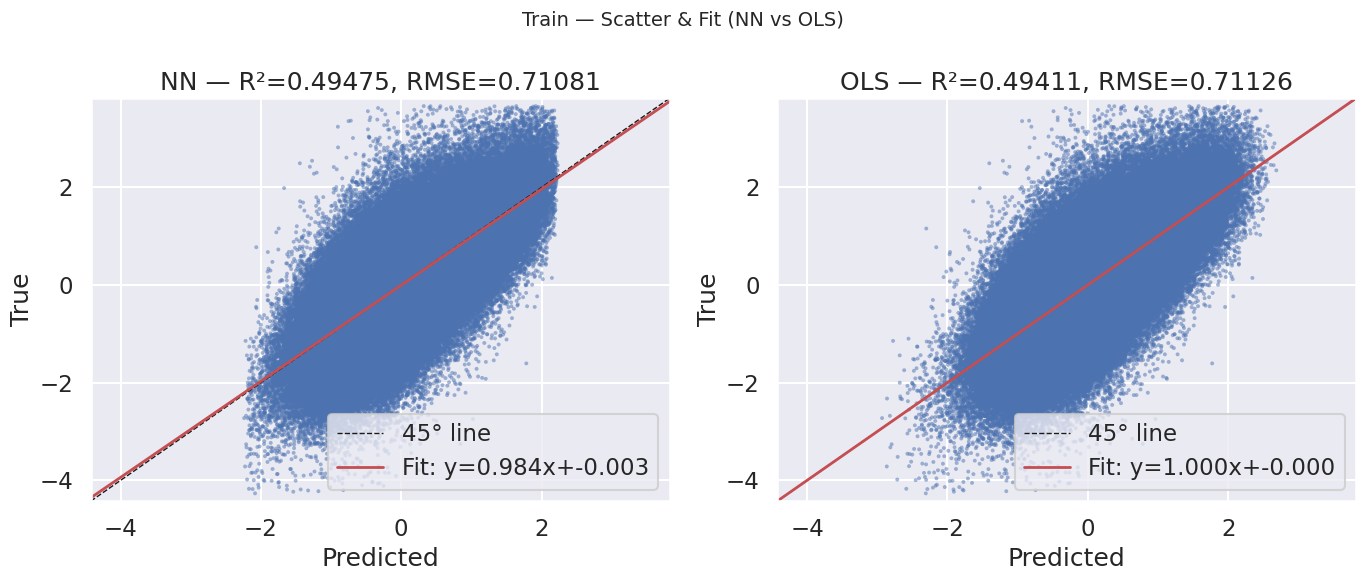

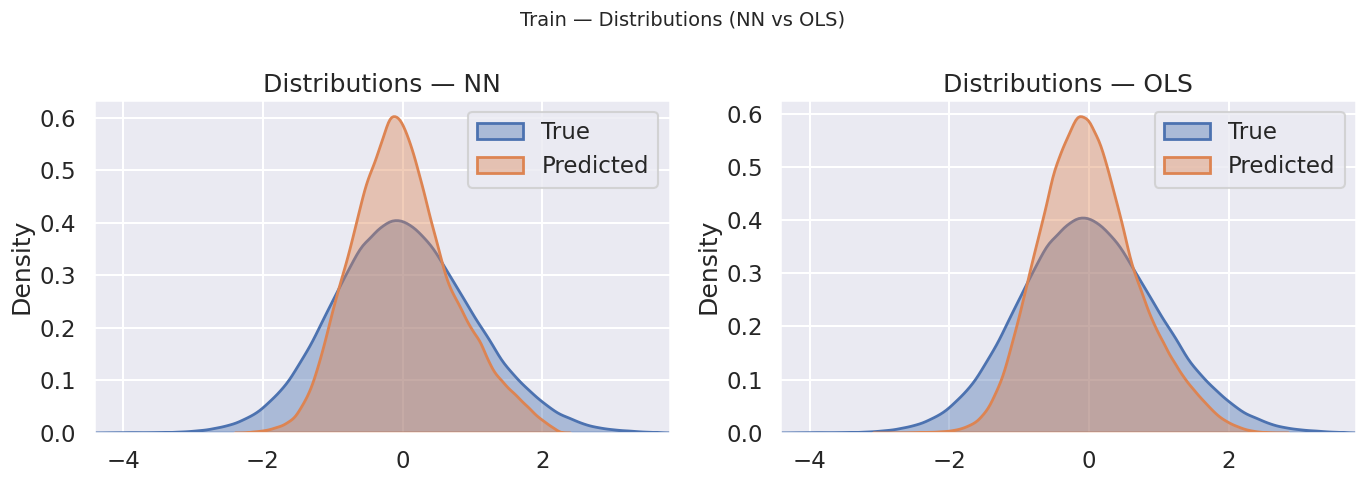

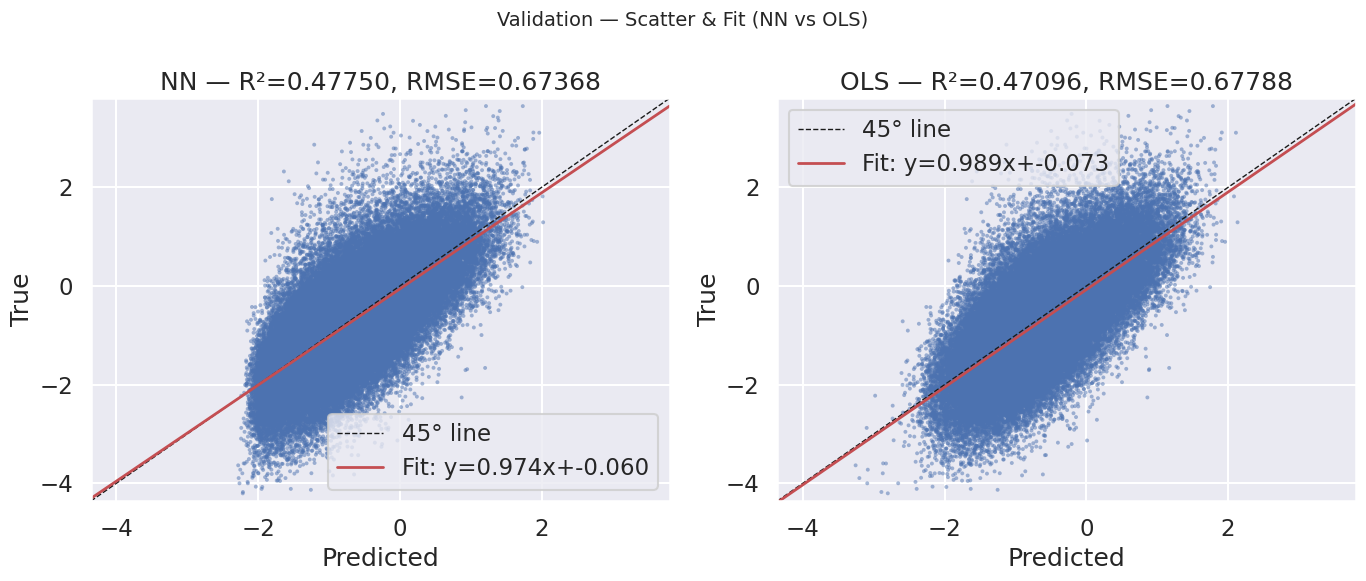

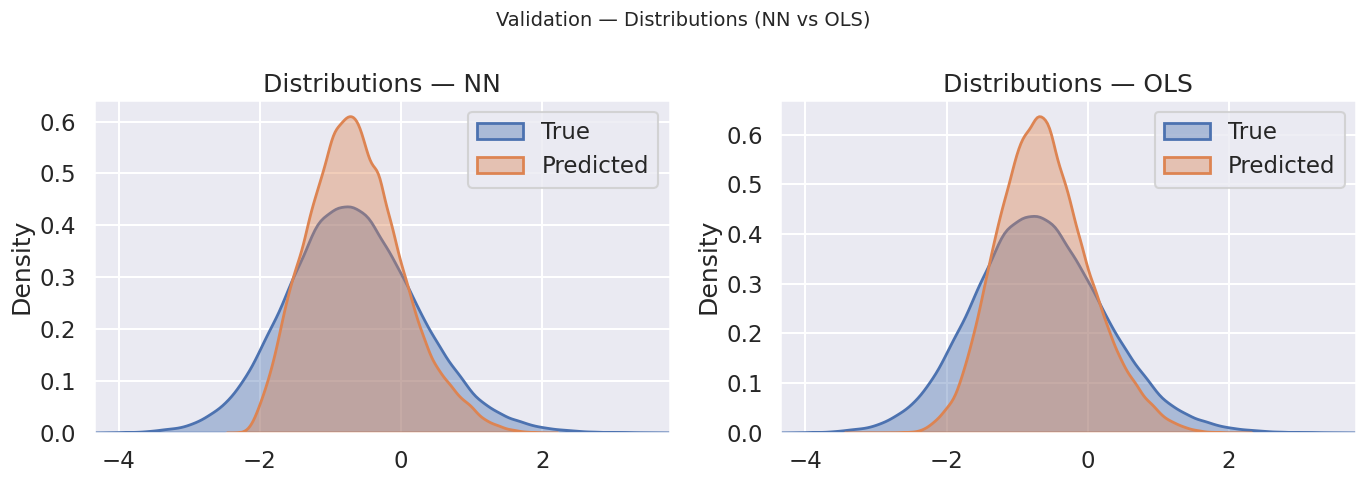

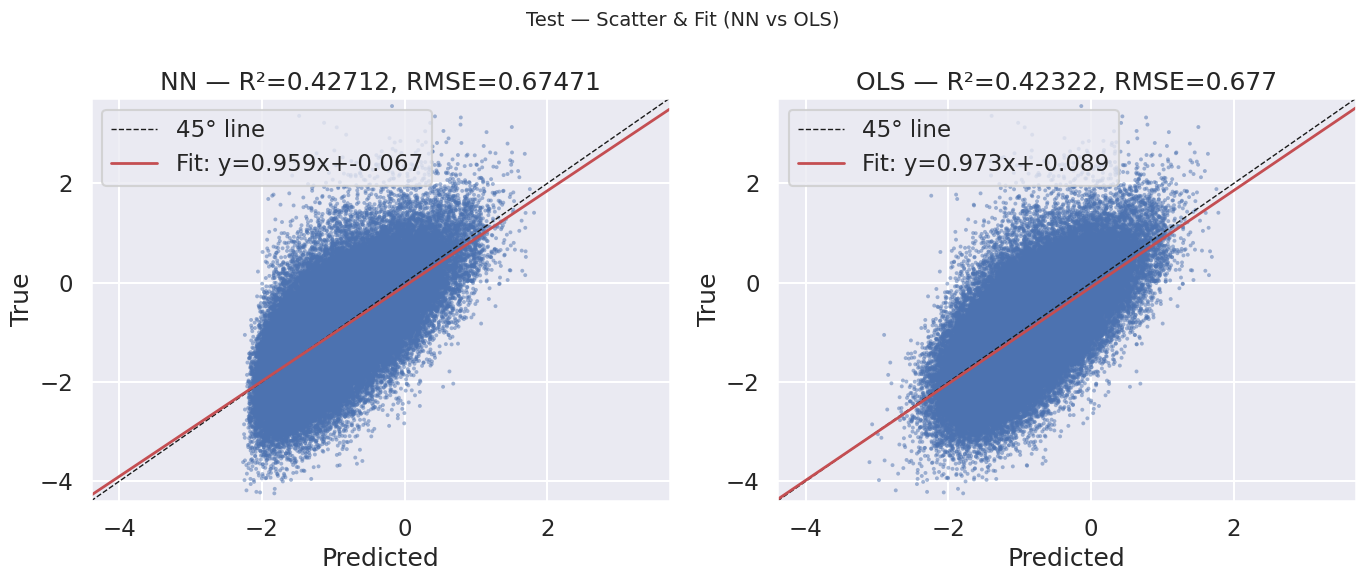

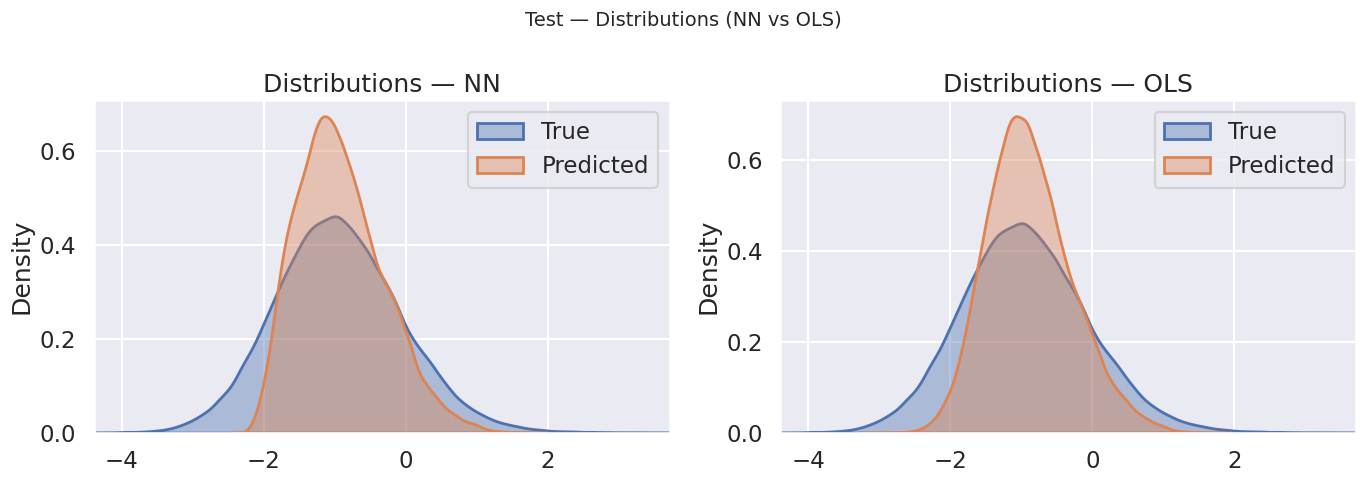

In [10]:
# old lines (now simplified)
model, trdata, vdata, tedata = eval_and_plot_simple(
    cfg,
    input_shape=None,         # you can even pass None now — it’s inferred
    output_shape=None,        # optional, inferred if missing
    ckpt=checkpoint,
    datasets=data[fold_num],
    device="cuda"
)


In [11]:
fold = 0
while True:    
    print("-"*50)
    print(f'fold: {fold}')
    try:
        for arr in data[fold]:
            print(f"{np.mean(arr):.4f}, {np.std(arr):.4f}, {np.percentile(arr, q=[0.05, 0.25, 0.5, 0.75, 0.95])},{np.min(arr):.4f}, {np.max(arr):.4f}")
        fold +=1
    except KeyError:
        break

--------------------------------------------------
fold: 0
-0.0000, 1.0000, [-3.28004413 -2.74719628 -2.52036837 -2.37032195 -2.2854488 ],-4.3129, 3.6675
0.0000, 1.0000, [-3.32369628 -2.75327327 -2.5111385  -2.36569376 -2.27764803],-4.2653, 3.6623
-0.6254, 0.9201, [-3.5556271  -3.10090254 -2.88523825 -2.75418679 -2.68309655],-4.2291, 3.6525
-0.6901, 0.9320, [-3.63742419 -3.2513039  -3.01305417 -2.87941934 -2.79376167],-4.2027, 3.6473
-0.9433, 0.8952, [-3.69946142 -3.2872397  -3.10888938 -2.99438278 -2.92432855],-4.2890, 3.5619
-0.9503, 0.8914, [-3.71434646 -3.28908687 -3.1112709  -3.00123111 -2.92719499],-4.2415, 3.5572
-0.0000, 1.0000, [-3.28004413 -2.74719628 -2.52036837 -2.37032195 -2.2854488 ],-4.3129, 3.6675
0.0000, 1.0000, [-3.32369628 -2.75327327 -2.5111385  -2.36569376 -2.27764803],-4.2653, 3.6623
-0.6254, 0.9201, [-3.5556271  -3.10090254 -2.88523825 -2.75418679 -2.68309655],-4.2291, 3.6525
-0.6901, 0.9320, [-3.63742419 -3.2513039  -3.01305417 -2.87941934 -2.79376167],-4.2027, 

0.0000, 1.0000, [-3.19304336 -2.68798403 -2.46748351 -2.32949894 -2.24597264],-4.1268, 3.7487
0.0000, 1.0000, [-3.24439734 -2.7188546  -2.48234861 -2.34512873 -2.26156084],-3.9967, 3.7231
-0.7841, 0.8804, [-3.49977683 -3.0884726  -2.9146331  -2.80191802 -2.73390264],-4.1033, 3.6446
-0.7686, 0.8681, [-3.46018619 -3.04607119 -2.87291517 -2.76575914 -2.69366325],-3.9735, 3.6208
--------------------------------------------------
fold: 1
-0.0000, 1.0000, [-3.07011866 -2.619742   -2.40771446 -2.2775295  -2.19929258],-3.7308, 3.8042
0.0000, 1.0000, [-3.10301686 -2.65238117 -2.42899976 -2.30036912 -2.21588047],-3.6278, 3.7928
-0.6646, 0.8885, [-3.33330388 -2.97144296 -2.80779656 -2.69498317 -2.62860231],-3.7306, 3.7010
-0.6511, 0.8804, [-3.30724856 -2.94830517 -2.77940518 -2.67348659 -2.60406768],-3.6275, 3.6138
-0.7370, 0.8483, [-3.33546595 -2.94471746 -2.76197435 -2.65484986 -2.58704219],-3.7282, 3.7210
-0.7048, 0.8372, [-3.26643224 -2.88049428 -2.70221638 -2.59702328 -2.53212638],-3.6252, 3

In [12]:
def plot_training_history(ckpt):
    """Plot train vs validation loss curves from the saved checkpoint."""
    history = ckpt.get("history", None)
    if not history:
        print("No training history found in checkpoint.")
        return

    # Convert list of dicts to separate arrays
    tr_losses = [h["tr_loss"] for h in history]
    val_losses = [h["val_loss"] for h in history]
    epochs = np.arange(1, len(tr_losses) + 1)

    sns.set_theme(style="whitegrid", context="talk")
    plt.figure(figsize=(7,5))
    plt.plot(epochs, tr_losses, label="Train Loss", lw=2)
    plt.plot(epochs, val_losses, label="Val Loss", lw=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_training_history(checkpoint)

KeyError: 'val_loss'

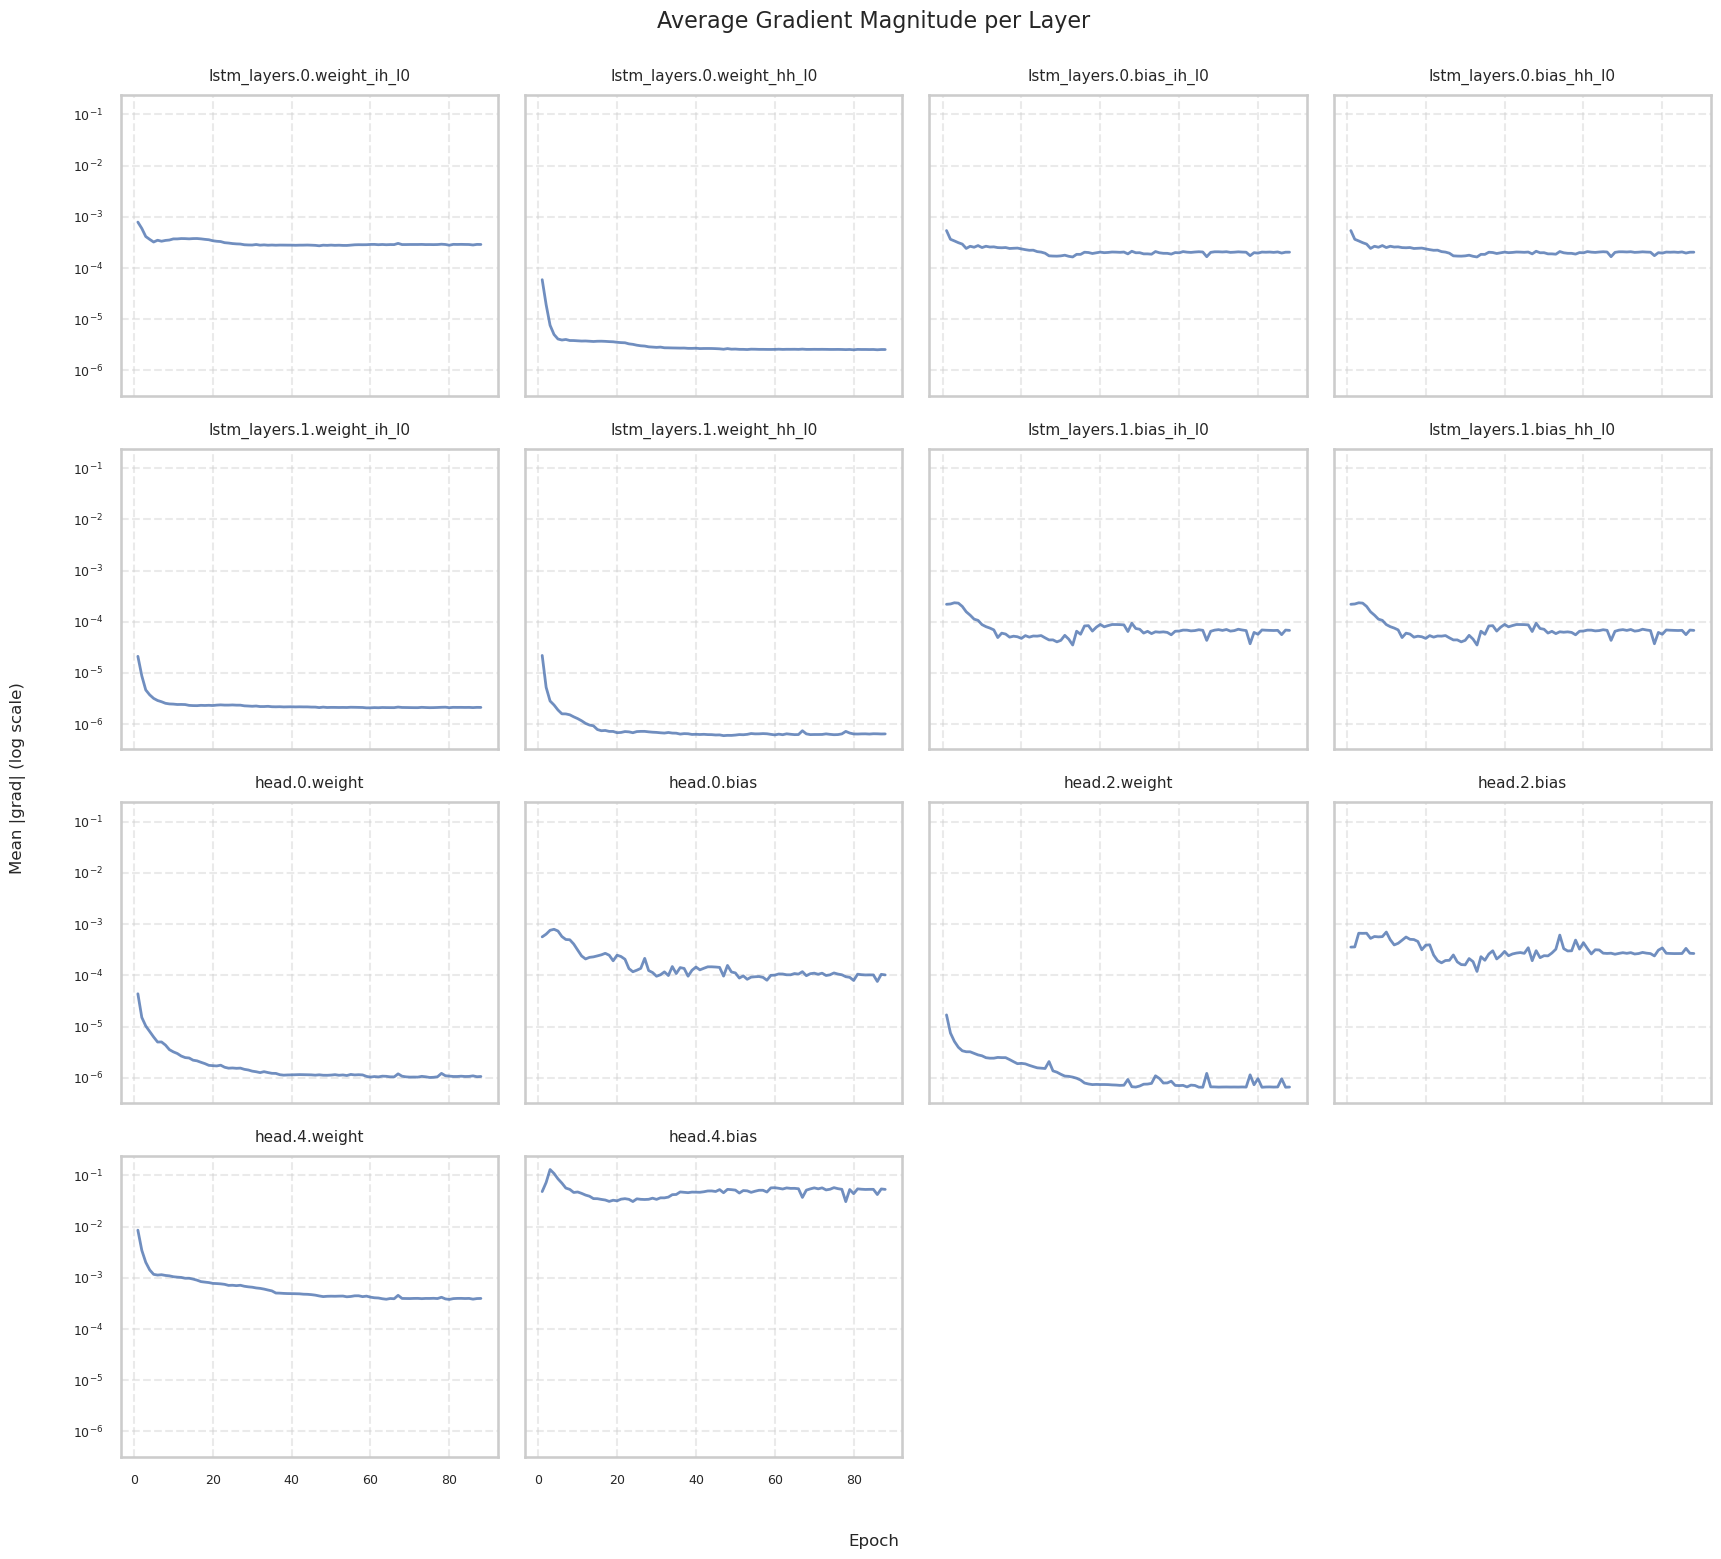

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import math

def plot_grad(ckpt):
    grad_history = ckpt.get("grad_history", [])
    if not grad_history:
        print("No grad_history found in checkpoint.")
        return

    df = pd.DataFrame(grad_history)
    if "epoch" not in df.columns:
        print("No 'epoch' column found in grad_history.")
        return

    df.set_index("epoch", inplace=True)
    
    # Clean column names for display (remove prefixes like _orig_mod.)
    df.columns = [c.replace("_orig_mod.", "") for c in df.columns]

    # --- grid setup ---
    n_cols = 4
    n_layers = len(df.columns)
    n_rows = math.ceil(n_layers / n_cols)

    # Increase figure size and adjust spacing
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        ax = axes[i]
        ax.plot(df.index, df[col], lw=2, alpha=0.8)
        ax.set_title(col, fontsize=11, pad=10)
        ax.set_yscale("log")
        ax.grid(True, linestyle="--", alpha=0.4)
        
        # Improve tick label formatting
        ax.tick_params(axis='both', which='major', labelsize=9)
        ax.tick_params(axis='both', which='minor', labelsize=7)
    
    # Hide empty tiles if #layers < grid size
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout with more padding
    plt.tight_layout(rect=[0.04, 0.04, 0.98, 0.96])  # [left, bottom, right, top]
    
    # Add titles with proper positioning
    fig.suptitle("Average Gradient Magnitude per Layer", fontsize=16, y=0.98)
    fig.text(0.5, 0.02, "Epoch", ha="center", fontsize=12)
    fig.text(0.02, 0.5, "Mean |grad| (log scale)", va="center", rotation="vertical", fontsize=12)
    
    plt.show()

plot_grad(checkpoint)

In [ ]:
ckpt = checkpoint
grad_history = ckpt.get("grad_history", [])

df = pd.DataFrame(grad_history)

df.set_index("epoch", inplace=True)

# Clean column names for display (remove prefixes like _orig_mod.)
df.columns = [c.replace("_orig_mod.", "") for c in df.columns]
df


,lstm_layers.0.weight_ih_l0,lstm_layers.0.weight_hh_l0,lstm_layers.0.bias_ih_l0,lstm_layers.0.bias_hh_l0,lstm_layers.1.weight_ih_l0,lstm_layers.1.weight_hh_l0,lstm_layers.1.bias_ih_l0,lstm_layers.1.bias_hh_l0,head.0.weight,head.0.bias,head.2.weight,head.2.bias,head.4.weight,head.4.bias
epoch,,,,,,,,,,,,,,
1,0.000789,0.000059,0.000540,0.000540,0.000021,2.193961e-05,0.000219,0.000219,0.000044,0.000565,1.690854e-05,0.000357,0.008525,0.048364
2,0.000594,0.000019,0.000365,0.000365,0.000009,5.230701e-06,0.000222,0.000222,0.000015,0.000638,7.480910e-06,0.000360,0.003437,0.072782
3,0.000413,0.000008,0.000339,0.000339,0.000005,2.827930e-06,0.000234,0.000234,0.000010,0.000759,5.132684e-06,0.000665,0.002008,0.130246
4,0.000363,0.000005,0.000313,0.000313,0.000004,2.364782e-06,0.000231,0.000231,0.000008,0.000794,3.947967e-06,0.000662,0.001428,0.109139
5,0.000323,0.000004,0.000294,0.000294,0.000003,1.888497e-06,0.000199,0.000199,0.000006,0.000735,3.369386e-06,0.000665,0.001169,0.085742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,0.000289,0.000003,0.000202,0.000202,0.000002,6.396149e-07,0.000067,0.000067,0.000001,0.000102,6.584410e-07,0.000267,0.000394,0.053446
85,0.000288,0.000003,0.000206,0.000206,0.000002,6.488783e-07,0.000068,0.000068,0.000001,0.000102,6.623234e-07,0.000267,0.000396,0.053466
86,0.000282,0.000003,0.000196,0.000196,0.000002,6.469025e-07,0.000056,0.000056,0.000001,0.000076,9.561285e-07,0.000336,0.000383,0.042340
